In [1]:
import numpy as np
import matplotlib.pyplot as plt
# from imblearn.metrics import sensitivity_specificity_support as sss
from sklearn.metrics import  f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc, roc_auc_score, confusion_matrix as CM

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Conv3D, GlobalAveragePooling3D,  MaxPooling3D, LeakyReLU, BatchNormalization, Dropout, Flatten, Activation, Reshape,  Conv3DTranspose, UpSampling3D
from tensorflow.keras.regularizers import l2, l1, l1_l2

/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ma-user/anaconda3/envs/TensorFlow-1.13.1/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ma-u

In [4]:
def data_filter(data, label, exclu):
    a1=np.where(label!=exclu[0] )[0]
    a2=np.where(label!=exclu[1] )[0]
    idx=np.intersect1d(a1,a2)
#     idx = np.where(label!= exclu)[0]
    #print(len(idx))
    data_new = data[idx]
    label_new = label[idx]
    #print(data_new.shape)
    print(np.unique(label_new, return_counts=True))
    return data_new, label_new

# onehot encode labels for binary classifications
def onehot_bi(y):
    from sklearn.preprocessing import OneHotEncoder
    onehot_encoder = OneHotEncoder(sparse=False)
    y = y.reshape(len(y), 1)
    y_encoded = onehot_encoder.fit_transform(y)
    return y_encoded

# onehot encode labels for 3-way classifications
def onehot_tri(y):
    from keras.utils import to_categorical
    return to_categorical(y)

# view the distribution of class labels of the input data
def showpercentage(array):
    pcn = array[1][0]/np.sum(array[1])
    pmci = array[1][1]/np.sum(array[1])
    pad = array[1][2]/np.sum(array[1])
    smci = array[1][3]/np.sum(array[1])
    print(str(pad) + " percent of the data has AD label")
    print(str(pcn) + " percent of the data has CN label")
    print(str(pmci) + " percent of the data has pMCI label")
    print(str(smci) + " percent of the data has sMCI label")

#%%
# models

# build the baseline model
def run_base(X_train, y_train, X_valid = None, y_valid = None, 
             final = False, out = 2,
             dr = 0.02, lr = 0.00001, 
             breg = l2(0.0001), areg = None, 
             n_epochs = 30, batch_size = 15):
  
    dim = (64, 64, 64, 1)

    model = Sequential()
    model.add(Conv3D(32, kernel_size=(5,5,5),  kernel_initializer='he_uniform', bias_regularizer=breg, input_shape=dim))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2, 2, 2)))

    model.add(Conv3D(64, kernel_size=(5,5,5),  bias_regularizer=breg, kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))


    model.add(Conv3D(128, kernel_size=(5,5,5),  bias_regularizer=breg, kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Dropout(dr))

    model.add(Flatten())
    model.add(Dense(512, bias_regularizer=breg,   kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dropout(dr))

    model.add(Dense(256, bias_regularizer=breg,   kernel_initializer='he_uniform'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(out, activation='softmax', activity_regularizer=areg))

    # model optimization
    opt = Adam(lr = lr)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy']) 

    cb = ReduceLROnPlateau(monitor = 'val_loss', 
                         factor = 0.5, patience = 5, 
                         verbose = 1, epsilon = 1e-4, mode = 'min')
    
  # model training and fine-tuning
    if not final:
        hist = model.fit(X_train, y_train,
                     batch_size = batch_size, 
                     epochs = n_epochs,
                     callbacks=[cb],
                     validation_data = (X_valid, y_valid), 
                     shuffle = True)
  
  # model final training for testing (train + valid combined)
    else:
        hist = model.fit(X_train, y_train,
                  batch_size = batch_size, 
                  epochs = n_epochs,
                  callbacks=[cb],
                  shuffle = True)


    return model, hist


# build the convolutional autoencoder
def run_cae(X_train,  X_val, lr = 0.0001, 
        n_epochs = 100, batch_size = 10):
  
    dim = (64,64,64,1)

    inp = Input(dim)
    # Encoder
    e = Conv3D(32, (3, 3, 3), strides = 2, activation='elu',  kernel_initializer='he_uniform', padding = "same")(inp)
    e = Conv3D(64, (3, 3, 3), strides = 2, activation='elu',  kernel_initializer='he_uniform', padding = "same")(e)
    e = Conv3D(1, (3, 3, 3), strides = 2,activation='elu',  kernel_initializer='he_uniform', padding = "same", name = "bottleneck")(e)

    #DECODER
    d = Conv3DTranspose(64,(3,3,3), strides = 2, kernel_initializer='he_uniform', activation='elu', padding = "same")(e)
    d = BatchNormalization()(d)
    d = Conv3DTranspose(16,(3,3,3), strides=2,  kernel_initializer='he_uniform', activation='elu', padding = "same")(d)
    d = BatchNormalization()(d)
    d = Conv3DTranspose(16,(3,3,3), strides=2,  kernel_initializer='he_uniform', activation='elu', padding = "same")(d)
    decoded = Conv3D(1, (3, 3, 3), activation='sigmoid', padding='same')(d)

    ae = Model(inp, decoded)

    # model optimization
    opt_ae = Adam(lr = lr)
    ae.compile(optimizer = opt_ae, loss = "mse")
    cb = ReduceLROnPlateau(monitor = 'val_loss', 
                         factor = 0.9, patience = 3, 
                         verbose = 1, mode = 'min')

    #Train it by providing training images
    ae.fit(X_train, X_train, 
         batch_size = batch_size, 
         epochs = n_epochs, 
         validation_data = (X_val, X_val), 
         verbose = 1,
         callbacks = [cb])

    return ae
  
#%%
  
# visualizatio of model traning and model performance 

# visualize the training and validation performance
def plot_history(data_list, label_list, title, ylabel, name):

    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title, pad = 10, fontsize='large')
    plt.xlabel('Epochs', labelpad=10)
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.show()
#%%

# model evaluation
    
# evaluate model performance - binary classifications
def evaluate_binary(X_test, y_test, model, name):
    test_y_prob = model.predict(X_test)
    print(test_y_prob)
    test_y_pred = np.argmax(test_y_prob, axis = 1)
    test_y_true = np.argmax(y_test, axis = 1) 
    # accuracy
    loss, acc = model.evaluate(X_test, y_test)
    # AUC
    pos_prob = test_y_prob[:,1]
    auc_score = roc_auc_score(test_y_true, pos_prob)
    # precision, recall, specificity, and f1_score
    p = precision_score(test_y_true, test_y_pred)
    r = recall_score(test_y_true, test_y_pred)
    f1 = f1_score(test_y_true, test_y_pred)
#     sen, spe, _ = sss(test_y_true, test_y_pred, average="binary")
    print(test_y_true, test_y_pred)
    # print results
    print("Test accuracy:", acc)
    print("Test AUC is: ", auc_score)
    print("Test confusion matrix: \n", CM(test_y_true, test_y_pred))
    print("Precision: ", p)
    print("Recall: ", r)
#     print("Specificity: ", spe)
    print("f1_score: ", f1)

    # plot and save roc curve
    pos_prob = test_y_prob[:,1]
    fpr, tpr, thresholds = roc_curve(test_y_true, pos_prob)
    ns_probs = [0 for _ in range(len(test_y_prob))]
    ns_fpr, ns_tpr, _ = roc_curve(test_y_true, ns_probs)
    plt.axis([0,1,0,1]) 
    plt.plot(fpr,tpr, marker = '.', color = 'darkorange', label = 'Model AUC (area = {:.2f})'.format(auc_score)) 
    plt.plot(ns_fpr, ns_tpr, color = 'royalblue', linestyle='--')
    plt.legend()
    plt.xlabel('False Positive Rate') 
    plt.ylabel('True Positive Rate') 
    plt.savefig(name, dpi=300, bbox_inches='tight')
    plt.show()

In [5]:
import logging
import numpy as np
import tensorflow as tf

In [6]:
Xtr = np.load("preprocess/input2/random_split/train_data.npy", allow_pickle = True)
ytr = np.load("preprocess/input2/random_split/train_label.npy", allow_pickle = True)
print(Xtr.shape)
print(ytr.shape)

Xts = np.load("preprocess/input2/random_split/test_data.npy", allow_pickle = True)
yts = np.load("preprocess/input2/random_split/test_label.npy", allow_pickle = True)
print(Xts.shape)
print(yts.shape)

Xval = np.load("preprocess/input2/random_split/val_data.npy", allow_pickle = True)
yval = np.load("preprocess/input2/random_split/val_label.npy", allow_pickle = True)
print(Xval.shape)
print(yval.shape)

print("Train:")
showpercentage(np.unique(ytr, return_counts=True))
print()
print("Validation:")
showpercentage(np.unique(yval, return_counts=True))
print()
print("Test")
showpercentage(np.unique(yts, return_counts=True))

(616, 64, 64, 64)
(616,)
(147, 64, 64, 64)
(147,)
(155, 64, 64, 64)
(155,)
Train:
0.16883116883116883 percent of the data has AD label
0.2418831168831169 percent of the data has CN label
0.16883116883116883 percent of the data has pMCI label
0.42045454545454547 percent of the data has sMCI label

Validation:
0.16774193548387098 percent of the data has AD label
0.24516129032258063 percent of the data has CN label
0.16774193548387098 percent of the data has pMCI label
0.41935483870967744 percent of the data has sMCI label

Test
0.16326530612244897 percent of the data has AD label
0.24489795918367346 percent of the data has CN label
0.17006802721088435 percent of the data has pMCI label
0.4217687074829932 percent of the data has sMCI label


In [ ]:
""" Baseline NC vs. AD """

# create input for binary classification of NC vs. AD
Xtr_ncad, ytr_ncad = data_filter(Xtr, ytr, [1,3])
Xval_ncad, yval_ncad = data_filter(Xval, yval, [1,3])
Xts_ncad, yts_ncad = data_filter(Xts, yts, [1,3])

# reshape the input
X_train = Xtr_ncad.reshape(-1,64,64,64,1) 
X_test = Xts_ncad.reshape(-1,64,64,64,1) 
X_val = Xval_ncad.reshape(-1,64,64,64,1) 


# one hot encode the target labels 
y_train = onehot_bi(ytr_ncad)
y_test = onehot_bi(yts_ncad)
y_val = onehot_bi(yval_ncad)



# model training
model, hist = run_base(X_train, y_train, X_val, y_val, 
                       breg = l2(0.001), areg = l1(0.001))
# model, hist = run_cae(X_train,  X_val, lr = 0.0001, 
#         n_epochs = 100, batch_size = 10)




(array([0, 2]), array([149, 104]))
(array([0, 2]), array([38, 26]))
(array([0, 2]), array([36, 24]))
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 253 samples, validate on 64 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30


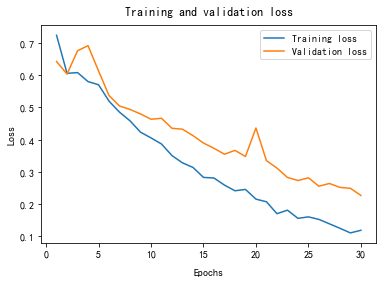

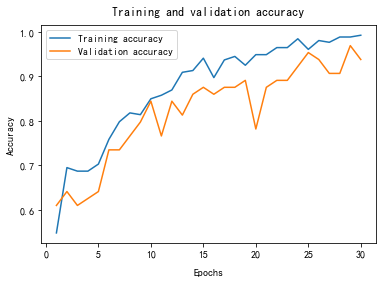

In [15]:
# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'base_ncad_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'base_ncad_acc')

[[0.976398   0.02360206]
 [0.8763993  0.12360077]
 [0.9019004  0.09809966]
 [0.88197803 0.1180219 ]
 [0.9623251  0.03767486]
 [0.9055547  0.09444533]
 [0.6871914  0.31280857]
 [0.89611214 0.10388784]
 [0.6833448  0.31665525]
 [0.26255524 0.73744476]
 [0.8904842  0.1095158 ]
 [0.25716797 0.742832  ]
 [0.00362898 0.99637103]
 [0.81236386 0.18763618]
 [0.15437135 0.8456286 ]
 [0.3977586  0.6022414 ]
 [0.0262274  0.9737726 ]
 [0.8755745  0.12442552]
 [0.9715892  0.02841077]
 [0.737255   0.26274505]
 [0.1412562  0.8587438 ]
 [0.721001   0.278999  ]
 [0.9590215  0.0409785 ]
 [0.8933298  0.10667024]
 [0.97769755 0.02230248]
 [0.81478655 0.18521342]
 [0.13098274 0.86901724]
 [0.7815799  0.21842004]
 [0.12285621 0.87714374]
 [0.70282024 0.2971798 ]
 [0.92631537 0.07368462]
 [0.94533813 0.05466194]
 [0.1386126  0.8613874 ]
 [0.01956543 0.9804346 ]
 [0.92959845 0.07040157]
 [0.9595619  0.04043813]
 [0.95586365 0.0441363 ]
 [0.14407276 0.8559272 ]
 [0.8232597  0.17674026]
 [0.00524079 0.99475914]


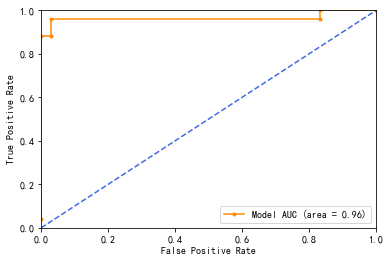

In [16]:
evaluate_binary(X_test, y_test, model, name = 'base_roc_ncad')

In [15]:
model.save("preprocess/model/220220316ADNC.h5")

(array([0, 1]), array([149, 104]))
(array([0, 1]), array([38, 26]))
(array([0, 1]), array([36, 25]))
Train on 253 samples, validate on 64 samples
Epoch 1/30
253/253 [==============================] - 3s 11ms/sample - loss: 0.6876 - acc: 0.5455 - val_loss: 0.6335 - val_acc: 0.6094
Epoch 2/30
253/253 [==============================] - 2s 7ms/sample - loss: 0.6795 - acc: 0.5968 - val_loss: 0.6238 - val_acc: 0.6406
Epoch 3/30
253/253 [==============================] - 2s 7ms/sample - loss: 0.6237 - acc: 0.6482 - val_loss: 0.6210 - val_acc: 0.6250
Epoch 4/30
253/253 [==============================] - 2s 7ms/sample - loss: 0.6114 - acc: 0.6680 - val_loss: 0.6461 - val_acc: 0.6250
Epoch 5/30
253/253 [==============================] - 2s 7ms/sample - loss: 0.6652 - acc: 0.6047 - val_loss: 0.7406 - val_acc: 0.4375
Epoch 6/30
253/253 [==============================] - 2s 7ms/sample - loss: 0.6197 - acc: 0.6245 - val_loss: 0.5846 - val_acc: 0.7812
Epoch 7/30
253/253 [=============================

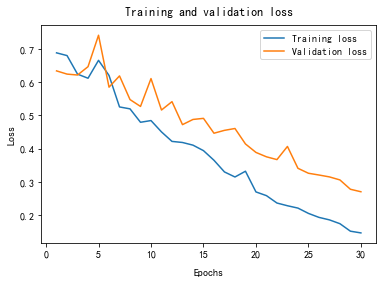

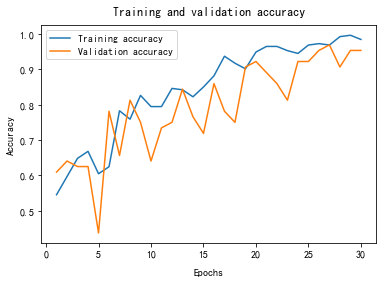

In [16]:
"""  Baseline NC vs. MCI """

# create input for binary classification of NC vs. MCI
Xtr_ncmci, ytr_ncmci = data_filter(Xtr, ytr, 2)
Xval_ncmci, yval_ncmci = data_filter(Xval, yval, 2)
Xts_ncmci, yts_ncmci = data_filter(Xts, yts, 2)

# reshape the input
X_train = Xtr_ncmci.reshape(-1,64,64,64,1) 
X_test = Xts_ncmci.reshape(-1,64,64,64,1) 
X_val = Xval_ncmci.reshape(-1,64,64,64,1) 

# one hot encode the target labels 
y_train = onehot_bi(ytr_ncmci)
y_test = onehot_bi(yts_ncmci)
y_val = onehot_bi(yval_ncmci)


# model training
model, hist = run_base(X_train, y_train, X_val, y_val, areg = l1(0.001))

# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'base_ncmci_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'base_ncmci_acc')

61/61 [==============================] - 0s 2ms/sample - loss: 0.2397 - acc: 0.9672
[0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0
 0 1 1 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0] [0 1 0 0 1 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 1 0
 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 0]
Test accuracy: 0.9672131
Test AUC is:  0.9944444444444444
Test confusion matrix: 
 [[36  0]
 [ 2 23]]
Precision:  1.0
Recall:  0.92
f1_score:  0.9583333333333334


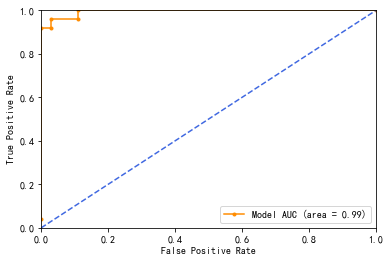

In [17]:
evaluate_binary(X_test, y_test, model, name = 'base_roc_ncmci')

In [18]:
"""  Baseline MCI vs. AD """

# create input for binary classification of MCI vs. AD
Xtr_admci, ytr_admci = data_filter(Xtr, ytr, 0)
Xval_admci, yval_admci = data_filter(Xval, yval, 0)
Xts_admci, yts_admci = data_filter(Xts, yts, 0)

# reshape the input
X_train = Xtr_admci.reshape(-1,64,64,64,1) 
X_test = Xts_admci.reshape(-1,64,64,64,1) 
X_val = Xval_admci.reshape(-1,64,64,64,1) 

# one hot encode the target labels 
y_train = onehot_bi(ytr_admci)
y_test = onehot_bi(yts_admci)
y_val = onehot_bi(yval_admci)


# model training
model, hist = run_base(X_train, y_train, X_val, y_val, dr = 0.03)





(array([1, 2]), array([104, 103]))
(array([1, 2]), array([26, 26]))
(array([1, 2]), array([25, 25]))
Train on 207 samples, validate on 52 samples
Epoch 1/30
207/207 [==============================] - 2s 10ms/sample - loss: 1.1002 - acc: 0.4879 - val_loss: 0.6777 - val_acc: 0.5385
Epoch 2/30
207/207 [==============================] - 1s 7ms/sample - loss: 0.7063 - acc: 0.5121 - val_loss: 0.6776 - val_acc: 0.5192
Epoch 3/30
207/207 [==============================] - 1s 7ms/sample - loss: 0.7212 - acc: 0.4831 - val_loss: 0.6841 - val_acc: 0.5000
Epoch 4/30
207/207 [==============================] - 1s 7ms/sample - loss: 0.6733 - acc: 0.5990 - val_loss: 0.6979 - val_acc: 0.5000
Epoch 5/30
207/207 [==============================] - 1s 7ms/sample - loss: 0.6817 - acc: 0.5507 - val_loss: 0.6674 - val_acc: 0.5769
Epoch 6/30
207/207 [==============================] - 1s 7ms/sample - loss: 0.6819 - acc: 0.5507 - val_loss: 0.6602 - val_acc: 0.5769
Epoch 7/30
207/207 [=============================

KeyError: 'accuracy'

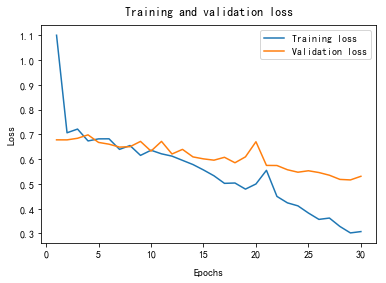

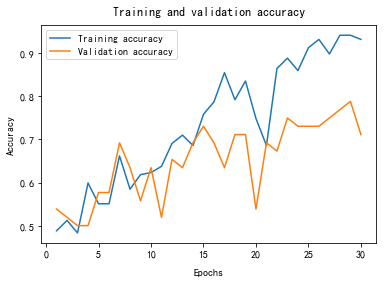

In [19]:
# visualization
history_dict = hist.history
#print(history_dict.keys())
acc = history_dict['acc']
val_acc = history_dict['val_acc']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

plot_history(data_list=[loss, val_loss],
             label_list=['Training loss', 'Validation loss'],
             title='Training and validation loss',
             ylabel='Loss', name = 'base_mciad_loss')
plot_history(data_list=[acc, val_acc],
             label_list=['Training accuracy', 'Validation accuracy'],
             title ='Training and validation accuracy',
             ylabel ='Accuracy', name = 'base_mciad_acc')

50/50 [==============================] - 0s 2ms/sample - loss: 0.4041 - acc: 0.8800
[0 0 0 0 0 0 1 1 0 1 0 1 1 0 1 0 0 1 0 0 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 1
 1 0 1 1 0 1 1 1 1 0 1 1 0] [0 1 0 0 0 0 0 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1 0 1 1 1 1 1 0 0 1 0 1 0 1 1
 1 0 1 1 0 1 1 1 1 0 1 1 0]
Test accuracy: 0.88
Test AUC is:  0.92
Test confusion matrix: 
 [[21  4]
 [ 2 23]]
Precision:  0.8518518518518519
Recall:  0.92
f1_score:  0.8846153846153846


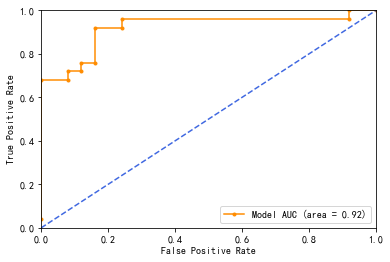

In [20]:
evaluate_binary(X_test, y_test, model, name = 'base_roc_mciad')